In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from importlib import reload
drive = reload(drive)

In [0]:
!pip install -q keras

In [0]:
!pip install Cython
!pip install git+git://github.com/scikit-learn/scikit-learn.git

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import re
import random
import os
import pickle

In [0]:
%matplotlib inline

import numpy as np
np.random.seed(6788)
import matplotlib.pyplot as plt

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
tf.set_random_seed(6788)

from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense, SimpleRNN, Activation, dot, concatenate, Bidirectional
from keras.models import Model, load_model

from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
MAX_LENGTH = 200
MIN_WORD_COUNT = 3
MAX_WORD_COUNT = 8

In [0]:
def normalize_string(s):
    s = re.sub(r"([.!?])", r" \1", s)
    return s


def filter_pair(p):
     return MAX_WORD_COUNT >= len(p[0].split(' ')) >= MIN_WORD_COUNT and \
        len(p[0]) <= MAX_LENGTH


def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]


def read_from_file(path):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(path, encoding='utf-16'). \
        read().strip().split('\n')

    # Split every line into data and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    return pairs


def prepare_data(path):
    pairs = read_from_file(path)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    return pairs

pairs = prepare_data("/content/drive/My Drive/final_year_project/data/all_corpus_sentence_pairs_v5.txt")
input_data = [row[0] for row in pairs]
output_data = [row[1] for row in pairs]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.1, random_state=42)

In [0]:
# Placeholder for max lengths of input and output which are user configurable constants
max_input_length = None
max_output_length = None

char_start_encoding = 1
char_padding_encoding = 0


def build_sequence_encode_decode_dicts(input_data):
    encoding_dict = {}
    decoding_dict = {}
    for line in input_data:
        for char in line:
            if char not in encoding_dict:
                # Using 2 + because our sequence start encoding is 1 and padding encoding is 0
                encoding_dict[char] = 2 + len(encoding_dict)
                decoding_dict[2 + len(decoding_dict)] = char

    return encoding_dict, decoding_dict, len(encoding_dict) + 2

In [0]:
def encode_sequences(encoding_dict, sequences, max_length):
    encoded_data = np.zeros(shape=(len(sequences), max_length))
    for i in range(len(sequences)):
        for j in range(min(len(sequences[i]), max_length)):
            encoded_data[i][j] = encoding_dict[sequences[i][j]]
    return encoded_data

In [0]:
def decode_sequence(decoding_dict, sequence):
    text = ''
    for i in sequence:
        if i == 0:
            break
        text += decoding_dict[i]
    return text

In [0]:
def generate(text, input_encoding_dict, model, max_input_length, max_output_length, beam_size, max_beams,
             min_cut_off_len, cut_off_ratio):
    min_cut_off_len = max(min_cut_off_len, cut_off_ratio * len(text))
    min_cut_off_len = min(min_cut_off_len, max_output_length)

    encoder_input = encode_sequences(input_encoding_dict, [text], max_input_length)

    completed_beams = []
    running_beams = [
        [np.zeros(shape=(len(encoder_input), max_output_length)), [1]]
    ]
    running_beams[0][0][:, 0] = char_start_encoding

    while len(running_beams) != 0:
        running_beams = sorted(running_beams, key=lambda tup: np.prod(tup[1]), reverse=True)
        running_beams = running_beams[:max_beams]

        temp_running_beams = []
        for running_beam, probs in running_beams:
            if len(probs) >= min_cut_off_len:
                completed_beams.append([running_beam[:, 1:], probs])
            else:
                prediction = model.predict([encoder_input, running_beam])[0]
                sorted_args = prediction.argsort()
                sorted_probs = np.sort(prediction)

                for i in range(1, beam_size + 1):
                    temp_running_beam = np.copy(running_beam)
                    i = -1 * i
                    ith_arg = sorted_args[:, i][len(probs)]
                    ith_prob = sorted_probs[:, i][len(probs)]

                    temp_running_beam[:, len(probs)] = ith_arg
                    temp_running_beams.append([temp_running_beam, probs + [ith_prob]])

        running_beams = [b for b in temp_running_beams]

    return completed_beams

In [0]:
def infer(text, model, params, beam_size=3, max_beams=3, min_cut_off_len=10, cut_off_ratio=1.5):
    input_encoding_dict = params['input_encoding']
    output_decoding_dict = params['output_decoding']
    max_input_length = params['max_input_length']
    max_output_length = params['max_output_length']

    decoder_outputs = generate(text, input_encoding_dict, model, max_input_length, max_output_length, beam_size,
                               max_beams, min_cut_off_len, cut_off_ratio)
    outputs = []
    for decoder_output, probs in decoder_outputs:
        outputs.append({'sequence': decode_sequence(output_decoding_dict, decoder_output[0]), 'prob': np.prod(probs)})

    return outputs

In [0]:
def generate_greedy(text, input_encoding_dict, model, max_input_length, max_output_length):
    encoder_input = encode_sequences(input_encoding_dict, [text], max_input_length)
    decoder_input = np.zeros(shape=(len(encoder_input), max_output_length))
    decoder_input[:, 0] = char_start_encoding
    for i in range(1, max_output_length):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:, i] = output[:, i]

        if decoder_input[:, i] == char_padding_encoding:
            return decoder_input[:, 1:]

    return decoder_input[:, 1:]

In [0]:
def infer_greedy(text, model, params):
    input_encoding_dict = params['input_encoding']
    output_decoding_dict = params['output_decoding']
    max_input_length = params['max_input_length']
    max_output_length = params['max_output_length']

    decoder_output = generate_greedy(text, input_encoding_dict, model, max_input_length, max_output_length)
    return decode_sequence(output_decoding_dict, decoder_output[0])

In [0]:
def build_params(input_data=[], output_data=[], params_path='test_params', max_lengths=(5, 5)):
    if os.path.exists(params_path):
        print('Loading the params file')
        params = pickle.load(open(params_path, 'rb'))
        return params

    print('Creating params file')
    input_encoding, input_decoding, input_dict_size = build_sequence_encode_decode_dicts(input_data)
    output_encoding, output_decoding, output_dict_size = build_sequence_encode_decode_dicts(output_data)
    params = {}
    params['input_encoding'] = input_encoding
    params['input_decoding'] = input_decoding
    params['input_dict_size'] = input_dict_size
    params['output_encoding'] = output_encoding
    params['output_decoding'] = output_decoding
    params['output_dict_size'] = output_dict_size
    params['max_input_length'] = max_lengths[0]
    params['max_output_length'] = max_lengths[1]

    os.makedirs(os.path.dirname(params_path), exist_ok=True)
    with open(params_path, 'wb') as f:
        pickle.dump(params, f)
    return params

In [0]:
def convert_training_data(input_data, output_data, params):
    input_encoding = params['input_encoding']
    input_decoding = params['input_decoding']
    input_dict_size = params['input_dict_size']
    output_encoding = params['output_encoding']
    output_decoding = params['output_decoding']
    output_dict_size = params['output_dict_size']
    max_input_length = params['max_input_length']
    max_output_length = params['max_output_length']

    encoded_training_input = encode_sequences(input_encoding, input_data, max_input_length)
    encoded_training_output = encode_sequences(output_encoding, output_data, max_output_length)
    training_encoder_input = encoded_training_input
    training_decoder_input = np.zeros_like(encoded_training_output)
    training_decoder_input[:, 1:] = encoded_training_output[:, :-1]
    training_decoder_input[:, 0] = char_start_encoding
    training_decoder_output = np.eye(output_dict_size)[encoded_training_output.astype('int')]
    x = [training_encoder_input, training_decoder_input]
    y = [training_decoder_output]
    return x, y

In [0]:
def build_model(params_path='test/params', enc_lstm_units=128, unroll=True):
    # generateing the encoding, decoding dicts
    params = build_params(params_path=params_path)

    input_encoding = params['input_encoding']
    input_decoding = params['input_decoding']
    input_dict_size = params['input_dict_size']
    output_encoding = params['output_encoding']
    output_decoding = params['output_decoding']
    output_dict_size = params['output_dict_size']
    max_input_length = params['max_input_length']
    max_output_length = params['max_output_length']

    print('Input encoding', input_encoding)
    print('Input decoding', input_decoding)
    print('Output encoding', output_encoding)
    print('Output decoding', output_decoding)

    # We need to define the max input lengths and max output lengths before training the model.
    # We pad the inputs and outputs to these max lengths
    encoder_input = Input(shape=(max_input_length,))
    decoder_input = Input(shape=(max_output_length,))

    # Need to make the number of hidden units configurable
    encoder = Embedding(input_dict_size, enc_lstm_units, input_length=max_input_length, mask_zero=True)(encoder_input)
    # using concat merge mode since in my experiments it gave the best results same with unroll
    encoder = Bidirectional(LSTM(enc_lstm_units, return_sequences=True, unroll=unroll), merge_mode='concat')(encoder)
    encoder_last = encoder[:, -1, :]

    # using 2* enc_lstm_units because we are using concat merge mode
    # cannot use bidirectionals lstm for decoding (obviously!)

    decoder = Embedding(output_dict_size, 2 * enc_lstm_units, input_length=max_output_length, mask_zero=True)(
        decoder_input)
    decoder = LSTM(2 * enc_lstm_units, return_sequences=True, unroll=unroll)(decoder,
                                                                             initial_state=[encoder_last, encoder_last])

    # luong attention
    attention = dot([decoder, encoder], axes=[2, 2])
    attention = Activation('softmax', name='attention')(attention)

    context = dot([attention, encoder], axes=[2, 1])

    decoder_combined_context = concatenate([context, decoder])

    output = TimeDistributed(Dense(enc_lstm_units, activation="tanh"))(decoder_combined_context)
    output = TimeDistributed(Dense(output_dict_size, activation="softmax"))(output)

    model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model, params

In [0]:
build_params(input_data=X_train, output_data=y_train, params_path='/content/drive/My Drive/final_year_project/checkpoints/params', max_lengths=(200, 200))

Creating params file


{'input_decoding': {2: 'ජ',
  3: 'ෝ',
  4: 'ත',
  5: 'ි',
  6: ' ',
  7: 'ඔ',
  8: 'බ',
  9: 'ේ',
  10: 'හ',
  11: 'ඬ',
  12: 'අ',
  13: 'ම',
  14: 'ර',
  15: 'ණ',
  16: 'ී',
  17: 'ය',
  18: '.',
  19: '්',
  20: 'න',
  21: 'ො',
  22: 'ට',
  23: 'ප',
  24: 'ල',
  25: 'ස',
  26: 'ක',
  27: 'ෂ',
  28: 'ව',
  29: 'ා',
  30: 'ද',
  31: 'ෙ',
  32: 'ග',
  33: 'එ',
  34: 'ඉ',
  35: 'ශ',
  36: 'ඒ',
  37: 'ං',
  38: 'ඡ',
  39: 'ඟ',
  40: 'ු',
  41: 'ැ',
  42: 'ඇ',
  43: 'ූ',
  44: 'භ',
  45: 'ෑ',
  46: 'ඩ',
  47: 'ළ',
  48: 'උ',
  49: '\u200d',
  50: 'ෛ',
  51: 'ආ',
  52: 'ධ',
  53: 'ථ',
  54: 'ඹ',
  55: 'ඛ',
  56: 'ච',
  57: 'ඥ',
  58: 'ෘ',
  59: 'ෆ',
  60: 'ඝ',
  61: 'ඳ',
  62: 'ඤ',
  63: 'ඈ',
  64: 'ඕ',
  65: 'ඵ',
  66: 'ඊ',
  67: 'ෞ',
  68: 'ඖ',
  69: 'ඨ',
  70: 'ඍ',
  71: 'ඞ',
  72: 'ඌ',
  73: 'ඪ',
  74: 'ඣ',
  75: 'ඃ',
  76: 'ඓ',
  77: '¸',
  78: '\u0dfe',
  79: 'ෲ',
  80: '�',
  81: 'Ê',
  82: 'ෟ',
  83: '\xa0',
  84: '‚',
  85: '\u202c',
  86: '‒',
  87: '\u2003',
  88: '\x94',
  89: '

In [0]:
model, params = build_model(params_path='/content/drive/My Drive/final_year_project/checkpoints/params')

Loading the params file
Input encoding {'ජ': 2, 'ෝ': 3, 'ත': 4, 'ි': 5, ' ': 6, 'ඔ': 7, 'බ': 8, 'ේ': 9, 'හ': 10, 'ඬ': 11, 'අ': 12, 'ම': 13, 'ර': 14, 'ණ': 15, 'ී': 16, 'ය': 17, '.': 18, '්': 19, 'න': 20, 'ො': 21, 'ට': 22, 'ප': 23, 'ල': 24, 'ස': 25, 'ක': 26, 'ෂ': 27, 'ව': 28, 'ා': 29, 'ද': 30, 'ෙ': 31, 'ග': 32, 'එ': 33, 'ඉ': 34, 'ශ': 35, 'ඒ': 36, 'ං': 37, 'ඡ': 38, 'ඟ': 39, 'ු': 40, 'ැ': 41, 'ඇ': 42, 'ූ': 43, 'භ': 44, 'ෑ': 45, 'ඩ': 46, 'ළ': 47, 'උ': 48, '\u200d': 49, 'ෛ': 50, 'ආ': 51, 'ධ': 52, 'ථ': 53, 'ඹ': 54, 'ඛ': 55, 'ච': 56, 'ඥ': 57, 'ෘ': 58, 'ෆ': 59, 'ඝ': 60, 'ඳ': 61, 'ඤ': 62, 'ඈ': 63, 'ඕ': 64, 'ඵ': 65, 'ඊ': 66, 'ෞ': 67, 'ඖ': 68, 'ඨ': 69, 'ඍ': 70, 'ඞ': 71, 'ඌ': 72, 'ඪ': 73, 'ඣ': 74, 'ඃ': 75, 'ඓ': 76, '¸': 77, '\u0dfe': 78, 'ෲ': 79, '�': 80, 'Ê': 81, 'ෟ': 82, '\xa0': 83, '‚': 84, '\u202c': 85, '‒': 86, '\u2003': 87, '\x94': 88, '\x83': 89}
Input decoding {2: 'ජ', 3: 'ෝ', 4: 'ත', 5: 'ි', 6: ' ', 7: 'ඔ', 8: 'බ', 9: 'ේ', 10: 'හ', 11: 'ඬ', 12: 'අ', 13: 'ම', 14: 'ර', 15: 'ණ', 16: 'ී', 17: 

In [0]:
class MY_Generator(Sequence):

    def __init__(self, input_data, output_data, batch_size):
        self.input_data, self.output_data = input_data, output_data
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.input_data) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_X = self.input_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.output_data[idx * self.batch_size:(idx + 1) * self.batch_size]

        return convert_training_data(batch_X, batch_y, params)

In [0]:
batch_size = 128
num_of_epochs = 200

In [0]:
my_training_batch_generator = MY_Generator(X_train, y_train, batch_size)
my_validation_batch_generator = MY_Generator(X_test, y_test, batch_size)

In [0]:
checkpoint_path = "/content/drive/My Drive/final_year_project/checkpoints/checkpoint"

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

callbacks_list = [checkpoint, es]

In [0]:
# history = model.fit(input_data, output_data, validation_split=0.2, batch_size=64, epochs=200,
#               callbacks=callbacks_list, verbose=1)

history = model.fit_generator(generator=my_training_batch_generator,
                                          steps_per_epoch=(len(X_train) // batch_size),
                                          epochs=num_of_epochs,
                                          verbose=1,
                                          validation_data=my_validation_batch_generator,
                                          validation_steps=(len(X_test) // batch_size),
                                          max_queue_size=32,
                                          callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/200
1082/1082 [==============================] - 1337s 1s/step - loss: 1.2390 - acc: 0.6721 - val_loss: 0.1168 - val_acc: 0.9687

Epoch 00001: val_loss improved from inf to 0.11684, saving model to /content/drive/My Drive/final_year_project/checkpoints/checkpoint


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'strided_slice:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'strided_slice:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/200
1082/1082 [==============================] - 1098s 1s/step - loss: 0.0906 - acc: 0.9736 - val_loss: 0.0475 - val_acc: 0.9869

Epoch 00002: val_loss improved from 0.11684 to 0.04748, saving model to /content/drive/My Drive/final_year_project/checkpoints/checkpoint
Epoch 3/200
1082/1082 [==============================] - 1109s 1s/step - loss: 0.0267 - acc: 0.9923 - val_loss: 0.0179 - val_acc: 0.9945

Epoch 00003: val_loss improved from 0.04748 to 0.01793, saving model to /content/drive/My Drive/final_year_project/checkpoints/checkpoint
Epoch 4/200
1082/1082 [==============================] - 1104s 1s/step - loss: 0.0143 - acc: 0.9953 - val_loss: 0.0127 - val_acc: 0.9958

Epoch 00004: val_loss improved from 0.01793 to 0.01269, saving model to /content/drive/My Drive/final_year_project/checkpoints/checkpoint
Epoch 5/200
1082/1082 [==============================] - 1103s 1s/step - loss: 0.0117 - acc: 0.9961 - val_loss: 0.0114 - val_acc: 0.9959

Epoch 00005: val_loss improved fro

In [0]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


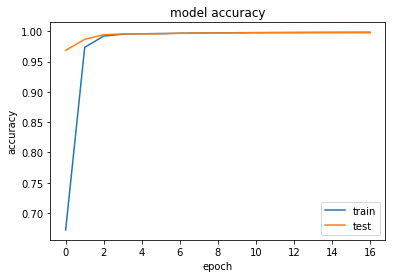

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

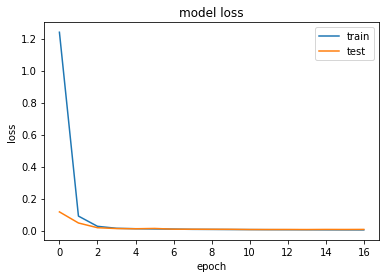

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()